1_ Elle a créé un tableau Excel qui permet d’établir le lien entre la référence du produit dans l’ERP (product_id) et la référence du même produit dans la base de la boutique en ligne (SKU).

2_ une fois le rapprochement effectué, je souhaiterais avoir le chiffre d’affaires par produit, ainsi que le total du chiffre d’affaires réalisé en ligne.

3_ je me demande s’il n’y a pas eu des erreurs de saisie dans certains prix des produits. J'aimerais que tu effectues une analyse sur cette variable afin de détecter d’éventuelles valeurs aberrantes, de les lister et d’en faire une représentation graphique pour plus de lisibilité.

Nous voudrions présenter tes résultats lors de la prochaine réunion de COPIL. Cela permettrait de montrer nos progrès. je te conseille de nous faire une présentation, mais tu peux également faire un notebook que tu présenteras à l’assemblée pour expliquer ta démarche et les incohérences (je pense que tu peux en trouver facilement au moins 5).

Tu as le fichier issu de l’ERP (erp.xlsx) et le fichier de la table produit de notre plateforme de vente en ligne (web.xlsx). Je te laisse prendre connaissance de ces éléments.

Je ne vais pas t’apprendre ton métier mais n’oublie pas les bonnes pratiques : 

    Pas de problème d’encodage
    Tester l’unicité des clés,
    Vérifier les jointures (type de jointure, nombre de produits jointés, etc.)
    Suppression ou modification des lignes justifiées


liste les product_id de l’ERP avec leur référence côté Web. La liste des product_id est exhaustive, mais pour les références côté Web, j’en suis moins sûre... J’ai peiné à rapprocher certaines références.

Je suis désolée, mais je me rends compte à l’instant que j’ai également mal nommé la colonne dans le fichier Excel. En fait, la colonne id_web dans mon fichier correspond au SKU des produits dans la boutique en ligne.

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.1 - Importation des librairies</h3>
</div>

In [70]:
# import les librairies pandas et numpy
import pandas as pd
import numpy as np

#on importe la librairie seaborn et matplotlib pour le rendu visuel

import seaborn as sns
import matplotlib.pyplot as plt

# pour eviter les messages d'erreurs
import warnings
warnings.filterwarnings(action='ignore')

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.2 - Chargement des fichiers Excel</h3>
</div>

In [71]:
# Import des fichiers excel 

erp = pd.read_excel('Fichier_erp.xlsx')

liaison = pd.read_excel('fichier_liaison.xlsx')

web = pd.read_excel('Fichier_web.xlsx')

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.3 - Exploration du fichier erp</h3>
</div>

In [72]:
# entreprise ressource planning

print("Nombre de ligne",erp.shape[0])
print("Nombre de colonne",erp.shape[1])

Nombre de ligne 825
Nombre de colonne 5


In [73]:
erp.info

<bound method DataFrame.info of      product_id  onsale_web  price  stock_quantity stock_status
0          3847           1   24.2               0   outofstock
1          3849           1   34.3               0   outofstock
2          3850           1   20.8               0   outofstock
3          4032           1   14.1               0   outofstock
4          4039           1   46.0               0   outofstock
..          ...         ...    ...             ...          ...
820        7203           0   45.0              30      instock
821        7204           0   45.0               9      instock
822        7247           1   54.8              23      instock
823        7329           0   26.5              14      instock
824        7338           1   16.3              45      instock

[825 rows x 5 columns]>

In [74]:
# nombre de lignes par colonne

erp.count()

product_id        825
onsale_web        825
price             825
stock_quantity    825
stock_status      825
dtype: int64

In [75]:
# vérification du types de chaque colonne du dataframe

erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [76]:
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [77]:
# verification d'un Nan ou null dans le dataframe

erp.isnull().sum()*100/erp.shape[0]

product_id        0.0
onsale_web        0.0
price             0.0
stock_quantity    0.0
stock_status      0.0
dtype: float64

In [78]:
# une premire incohérence, status 'instock' avec une quantité de stock de 0

erp.loc[(erp['stock_status']=='instock') & (erp['stock_quantity']==0)]

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock


In [79]:
# on trouve deux autre incohérence, prix négatifs. "5017" et "6594"

erp.loc[erp['price'] < 0, :]

,product_id,onsale_web,price,stock_quantity,stock_status
469,5017,0,-8.0,0,outofstock
739,6594,0,-1.0,192,instock


In [80]:
# filtre pour détecter les incohérences suivantes.

erp.loc[(erp['stock_status']== 'outofstock') & (erp['stock_quantity'] != 0)]

,product_id,onsale_web,price,stock_quantity,stock_status
19,4055,0,86.1,1,outofstock
49,4090,0,73.0,6,outofstock
50,4092,0,47.0,6,outofstock
449,4973,0,10.0,-1,outofstock
573,5700,1,44.5,-1,outofstock
630,5826,1,41.2,12,outofstock
696,6125,0,14.2,48,outofstock


In [81]:
# création du dataframe vérif stock

verif_stock = erp.loc[(erp['stock_status']== 'outofstock') & (erp['stock_quantity'] != 0)]

In [82]:
# filtre sur les ventes sur le web

verif_stock.loc[verif_stock['onsale_web'] != 0, :]

,product_id,onsale_web,price,stock_quantity,stock_status
573,5700,1,44.5,-1,outofstock
630,5826,1,41.2,12,outofstock


In [83]:
# on stock les product_id si besoin
# utile pour vérification dans le dataframe joint

list_product = [5700 , 5826]

In [84]:
# pas de doublon de 'product_id' dans le dafaframe

erp.loc[erp['product_id'].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.4 - Exploration du fichier web</h3>
</div>

In [85]:
print("Nombre de ligne",web.shape[0])
print("Nombre de colonne",web.shape[1])

Nombre de ligne 1513
Nombre de colonne 28


In [86]:
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,...,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15075,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-14 17:15:31,...,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,15763,0,0,0,0.0,1.0,NaN,NaN,2.0,2020-01-25 14:08:16,...,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [87]:
# types des données de chaque colonne

web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [88]:
# nombre de ligne pour chaque colonnes

web.count()

sku                      1428
virtual                  1513
downloadable             1513
rating_count             1513
average_rating           1430
total_sales              1430
tax_status                716
tax_class                   0
post_author              1430
post_date                1430
post_date_gmt            1430
post_content                0
post_title               1430
post_excerpt              716
post_status              1430
comment_status           1430
ping_status              1430
post_password               0
post_name                1430
post_modified            1430
post_modified_gmt        1430
post_content_filtered       0
post_parent              1430
guid                     1430
menu_order               1430
post_type                1430
post_mime_type            714
comment_count            1430
dtype: int64

In [89]:
# nombre de valeur manquante dans chaque colonne

web.isnull().sum()

sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

In [90]:
# pourcentages de valeurs nulls de chaque colonne

web.isnull().sum()*100/web.shape[0]

sku                        5.617978
virtual                    0.000000
downloadable               0.000000
rating_count               0.000000
average_rating             5.485790
total_sales                5.485790
tax_status                52.676801
tax_class                100.000000
post_author                5.485790
post_date                  5.485790
post_date_gmt              5.485790
post_content             100.000000
post_title                 5.485790
post_excerpt              52.676801
post_status                5.485790
comment_status             5.485790
ping_status                5.485790
post_password            100.000000
post_name                  5.485790
post_modified              5.485790
post_modified_gmt          5.485790
post_content_filtered    100.000000
post_parent                5.485790
guid                       5.485790
menu_order                 5.485790
post_type                  5.485790
post_mime_type            52.808989
comment_count              5

In [91]:
web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,...,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15075,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-14 17:15:31,...,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,15763,0,0,0,0.0,1.0,NaN,NaN,2.0,2020-01-25 14:08:16,...,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,12881,0,0,0,0.0,2.0,NaN,NaN,2.0,2019-03-28 15:25:14,...,montbourgeau-etoile-vin-jaune-2009,2019-12-30 10:30:01,2019-12-30 09:30:01,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15663,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-27 10:27:01,...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1510,15910,0,0,0,0.0,0.0,taxable,NaN,2.0,2019-03-28 10:59:43,...,thevenet-quintaine-vire-clesse-la-bongran-2015,2020-08-14 10:45:02,2020-08-14 08:45:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1511,38,0,0,0,0.0,38.0,NaN,NaN,2.0,2018-04-18 12:25:58,...,emile-boeckel-cremant-brut-blanc-de-blancs,2020-08-27 17:15:03,2020-08-27 15:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [92]:
# Copy du dataframe pour nettoyage pour éviter de toujours au jeu de donnée originel

df_web = web.copy()

# suppression des colonnes vides.
df_web.drop(['tax_class','post_content','post_password','post_content_filtered'], axis = 1, inplace = True)

In [93]:
df_web.isnull().sum()

sku                   85
virtual                0
downloadable           0
rating_count           0
average_rating        83
total_sales           83
tax_status           797
post_author           83
post_date             83
post_date_gmt         83
post_title            83
post_excerpt         797
post_status           83
comment_status        83
ping_status           83
post_name             83
post_modified         83
post_modified_gmt     83
post_parent           83
guid                  83
menu_order            83
post_type             83
post_mime_type       799
comment_count         83
dtype: int64

In [94]:

print(web.columns)
print()
print(df_web.columns)

Index(['sku', 'virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date',
       'post_date_gmt', 'post_content', 'post_title', 'post_excerpt',
       'post_status', 'comment_status', 'ping_status', 'post_password',
       'post_name', 'post_modified', 'post_modified_gmt',
       'post_content_filtered', 'post_parent', 'guid', 'menu_order',
       'post_type', 'post_mime_type', 'comment_count'],
      dtype='object')

Index(['sku', 'virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'post_author', 'post_date',
       'post_date_gmt', 'post_title', 'post_excerpt', 'post_status',
       'comment_status', 'ping_status', 'post_name', 'post_modified',
       'post_modified_gmt', 'post_parent', 'guid', 'menu_order', 'post_type',
       'post_mime_type', 'comment_count'],
      dtype='object')


In [95]:
# suppression des lignes valeur "nan" dans la colonne "sku"

df_web.dropna(axis=0, how='any', subset=['sku'], inplace=True)

In [96]:
# Vérification du nombre de valeurs null des différentes colonnes

df_web.isnull().sum()

sku                    0
virtual                0
downloadable           0
rating_count           0
average_rating         0
total_sales            0
tax_status           714
post_author            0
post_date              0
post_date_gmt          0
post_title             0
post_excerpt         714
post_status            0
comment_status         0
ping_status            0
post_name              0
post_modified          0
post_modified_gmt      0
post_parent            0
guid                   0
menu_order             0
post_type              0
post_mime_type       714
comment_count          0
dtype: int64

In [97]:
# filtrage sur 'taxable' de la colonne 'tax_status' pour éviter les doublons

df_web = df_web.loc[df_web['tax_status']== 'taxable', :]

In [98]:
# on ne trouve pas de doublons

df_web.loc[df_web['sku'].duplicated(keep=False),:]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count


In [99]:
df_web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,ping_status,post_name,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
2,15075,0,0,0,0.0,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,...,closed,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,...,closed,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
5,13895,0,0,0,0.0,0.0,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,...,closed,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
6,12857,0,0,0,0.0,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,...,closed,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
9,14106,0,0,0,0.0,0.0,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,...,closed,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,15941,0,0,0,0.0,4.0,taxable,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,...,closed,jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1503,10459,0,0,0,0.0,0.0,taxable,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,...,closed,alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1507,16320,0,0,0,0.0,3.0,taxable,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,...,closed,mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1509,15663,0,0,0,0.0,3.0,taxable,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,...,closed,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.5 - Exploration du fichier liaison</h3>
</div>

In [100]:
liaison.dtypes

product_id     int64
id_web        object
dtype: object

In [101]:
liaison.shape

(825, 2)

In [102]:
liaison.describe

<bound method NDFrame.describe of      product_id   id_web
0          3847    15298
1          3849    15296
2          3850    15300
3          4032    19814
4          4039    19815
..          ...      ...
820        7203      NaN
821        7204      NaN
822        7247  13127-1
823        7329  14680-1
824        7338    16230

[825 rows x 2 columns]>

In [103]:
# values dans un array

dictionnaire_product_id = df_web['sku'].values

# je vérifie si dans mon dataframe de la colonne 'id_web', est dans mon dictionnaire

mask = liaison['id_web'].isin(dictionnaire_product_id)

In [104]:
# convertir en dataframe

mask=mask.to_frame()

In [105]:
# filtrer sur les valeurs qui nont pas le lien entre les deux fichiers "liaison" et "df_web"

mask.loc[mask['id_web']==False]

,id_web
19,False
49,False
50,False
119,False
131,False
...,...
818,False
819,False
820,False
821,False


In [106]:
# recheche de l'index des lignes

index_verif = mask.loc[mask['id_web']==False].index

In [107]:
# visibilité des produits grace aux index

liaison.iloc[index_verif]

,product_id,id_web
19,4055,NaN
49,4090,NaN
50,4092,NaN
119,4195,NaN
131,4209,NaN
...,...,...
818,7200,NaN
819,7201,NaN
820,7203,NaN
821,7204,NaN


In [108]:
# dataframe pour la jointure

erp_without_id_web = liaison.iloc[index_verif]

In [109]:
# on jete un coup d'oeil sur les produits qui n'ont pas d'identifiant web

df_join_erp_whitout_id_web = pd.merge(erp_without_id_web, erp, on= 'product_id', how='inner')

In [110]:
# la jointure nous montre qu'il y a des produits non identifier sur le web

df_join_erp_whitout_id_web

,product_id,id_web,onsale_web,price,stock_quantity,stock_status
0,4055,NaN,0,86.1,1,outofstock
1,4090,NaN,0,73.0,6,outofstock
2,4092,NaN,0,47.0,6,outofstock
3,4195,NaN,0,14.1,0,outofstock
4,4209,NaN,0,73.5,0,outofstock
...,...,...,...,...,...,...
106,7200,NaN,0,31.0,6,instock
107,7201,NaN,0,31.0,18,instock
108,7203,NaN,0,45.0,30,instock
109,7204,NaN,0,45.0,9,instock


In [111]:
# je reviens sur le dataframe liaison
liaison

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [112]:
# création d'une copie du dataframe pour traitement /nettoyage 
df_liaison = liaison.copy()

In [113]:
df_liaison.count()

product_id    825
id_web        734
dtype: int64

In [114]:
print(df_web.dtypes)
print("________________")
print(liaison.dtypes)

sku                          object
virtual                       int64
downloadable                  int64
rating_count                  int64
average_rating              float64
total_sales                 float64
tax_status                   object
post_author                 float64
post_date            datetime64[ns]
post_date_gmt        datetime64[ns]
post_title                   object
post_excerpt                 object
post_status                  object
comment_status               object
ping_status                  object
post_name                    object
post_modified        datetime64[ns]
post_modified_gmt    datetime64[ns]
post_parent                 float64
guid                         object
menu_order                  float64
post_type                    object
post_mime_type               object
comment_count               float64
dtype: object
________________
product_id     int64
id_web        object
dtype: object


In [115]:
# jointure entre dataframe web et liaison sur la colonne identique au deux df
# j'ai fais le choix de conserver seulement les colonnes communes aux deux dataframes avec un inner


df_join_df_web_df_liaison = pd.merge(df_web, df_liaison, left_on= 'sku', right_on='id_web', how='inner')

In [116]:
df_join_df_web_df_liaison

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,post_modified,post_modified_gmt,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,product_id,id_web
0,15075,0,0,0,0.0,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,...,2020-08-20 15:35:02,2020-08-20 13:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4165,15075
1,16209,0,0,0,0.0,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,...,2020-08-05 18:05:03,2020-08-05 16:05:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4174,16209
2,13895,0,0,0,0.0,0.0,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,...,2020-04-25 21:11:40,2020-04-25 19:11:40,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,5796,13895
3,12857,0,0,0,0.0,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,...,2020-02-06 16:35:02,2020-02-06 15:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4582,12857
4,14106,0,0,0,0.0,0.0,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,...,2020-05-29 17:35:03,2020-05-29 15:35:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,6106,14106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,15941,0,0,0,0.0,4.0,taxable,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,...,2020-06-25 14:00:03,2020-06-25 12:00:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4074,15941
710,10459,0,0,0,0.0,0.0,taxable,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,...,2020-08-24 14:05:02,2020-08-24 12:05:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4617,10459
711,16320,0,0,0,0.0,3.0,taxable,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,...,2020-08-25 11:15:03,2020-08-25 09:15:03,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4062,16320
712,15663,0,0,0,0.0,3.0,taxable,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,...,2020-08-01 09:35:02,2020-08-01 07:35:02,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0,4262,15663


In [117]:
df_join_df_web_df_liaison.count()

sku                  714
virtual              714
downloadable         714
rating_count         714
average_rating       714
total_sales          714
tax_status           714
post_author          714
post_date            714
post_date_gmt        714
post_title           714
post_excerpt         714
post_status          714
comment_status       714
ping_status          714
post_name            714
post_modified        714
post_modified_gmt    714
post_parent          714
guid                 714
menu_order           714
post_type            714
post_mime_type         0
comment_count        714
product_id           714
id_web               714
dtype: int64

In [118]:
df_final = pd.merge(df_join_df_web_df_liaison, erp, how='inner', on=['product_id'],indicator=True)

In [119]:
df_final

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,post_type,post_mime_type,comment_count,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge
0,15075,0,0,0,0.0,3.0,taxable,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,...,product,NaN,0.0,4165,15075,1,12.0,57,instock,both
1,16209,0,0,0,0.0,6.0,taxable,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,...,product,NaN,0.0,4174,16209,1,5.7,94,instock,both
2,13895,0,0,0,0.0,0.0,taxable,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,...,product,NaN,0.0,5796,13895,1,12.5,12,instock,both
3,12857,0,0,0,0.0,0.0,taxable,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,...,product,NaN,0.0,4582,12857,1,109.6,7,instock,both
4,14106,0,0,0,0.0,0.0,taxable,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,...,product,NaN,0.0,6106,14106,1,74.8,15,instock,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,15941,0,0,0,0.0,4.0,taxable,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,...,product,NaN,0.0,4074,15941,1,12.7,50,instock,both
710,10459,0,0,0,0.0,0.0,taxable,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,...,product,NaN,0.0,4617,10459,1,67.5,1,instock,both
711,16320,0,0,0,0.0,3.0,taxable,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,...,product,NaN,0.0,4062,16320,1,11.9,60,instock,both
712,15663,0,0,0,0.0,3.0,taxable,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,...,product,NaN,0.0,4262,15663,1,15.8,35,instock,both


In [142]:
df_final['_merge'].count()

714

In [120]:
# je filtre sur le produit 

df_final.loc[(df_final['product_id']== 5700)]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,post_type,post_mime_type,comment_count,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge
585,14736,0,0,0,0.0,1.0,taxable,2.0,2019-01-31 11:58:26,2019-01-31 10:58:26,...,product,NaN,0.0,5700,14736,1,44.5,-1,outofstock,both


In [121]:
df_final.loc[(df_final['product_id']== 5826)]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,post_type,post_mime_type,comment_count,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge
17,15325,0,0,0,0.0,4.0,taxable,2.0,2019-03-27 17:59:49,2019-03-27 16:59:49,...,product,NaN,0.0,5826,15325,1,41.2,12,outofstock,both


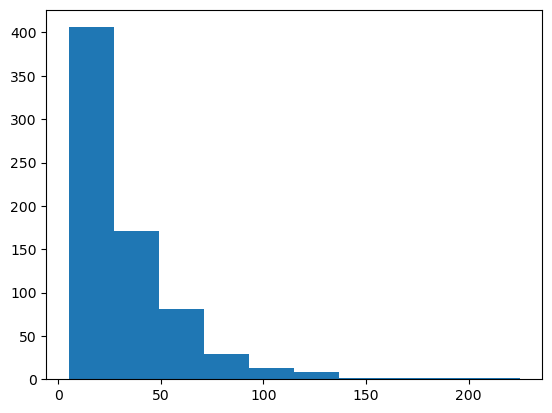

In [144]:
plt.hist(df_final['price'])

plt.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.0 - 1ere méthode pour visualiser les outliers</h3>
</div>

In [123]:
df_final.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_parent,menu_order,comment_count,product_id,onsale_web,price,stock_quantity
count,714.0,714.0,714.0,714.0,714.000000,714.000000,714.0,714.0,714.0,714.000000,714.0,714.000000,714.000000
mean,0.0,0.0,0.0,0.0,4.012605,1.998599,0.0,0.0,0.0,5032.557423,1.0,32.493137,28.761905
std,0.0,0.0,0.0,0.0,8.518183,0.037424,0.0,0.0,0.0,790.510878,0.0,27.810525,48.005486
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,3847.000000,1.0,5.200000,-1.000000
25%,0.0,0.0,0.0,0.0,0.000000,2.000000,0.0,0.0,0.0,4280.250000,1.0,14.100000,2.000000
50%,0.0,0.0,0.0,0.0,1.000000,2.000000,0.0,0.0,0.0,4796.000000,1.0,23.550000,12.000000
75%,0.0,0.0,0.0,0.0,4.000000,2.000000,0.0,0.0,0.0,5710.500000,1.0,42.175000,35.000000
max,0.0,0.0,0.0,0.0,96.000000,2.000000,0.0,0.0,0.0,7338.000000,1.0,225.000000,578.000000


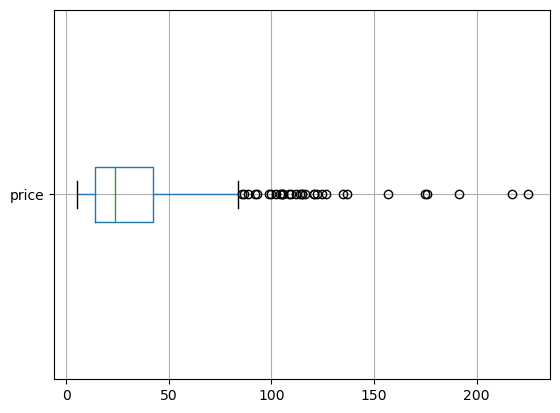

In [124]:
# boite à moustache
df_final.boxplot(column="price", vert=False)
plt.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.1 - 2ème méthode pour visualiser les outliers</h3>
</div>

In [127]:
df_final['price'].median()

23.55

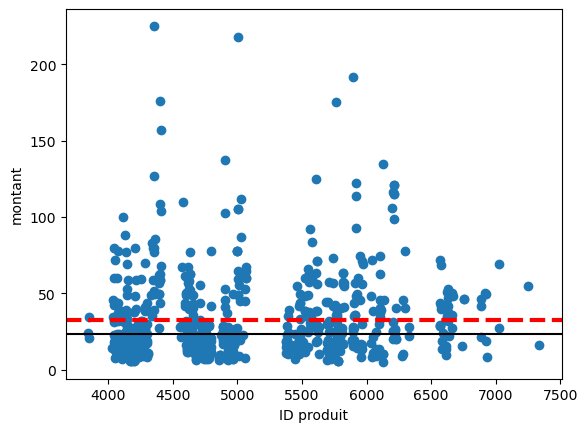

In [128]:
# graphique en nuage de point

plt.scatter(df_final['product_id'], df_final['price'])
plt.xlabel('ID produit')
plt.ylabel('montant')
plt.axhline(y=df_final['price'].median(), color='k')
plt.axhline(y=df_final['price'].mean(), color='red', linestyle='--', linewidth=3, label='Avg')
plt.show()

<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">4 - Chiffre d'affaire total (avec outliers)</h3>
</div>

In [129]:
# nouvelle colonne chiffre d'affaire produit avec condition 

df_final['CA_pro'] = df_final['total_sales'].apply(lambda x: 0 if x < 0 else x) * df_final['price']

In [130]:
#chiffre d'affaire total avant d'avoir trouver les outliers
print(df_final['CA_pro'].sum())

70568.6


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">3 - Écart interquartile</h3>
</div>

In [131]:
# le 1er quartile qui sépare les 25 % inférieurs des données

q1=df_final["price"].quantile(q=0.25)

In [132]:
# le 3eme quartile qui sépare les 75 % inférieurs des données

q3=df_final["price"].quantile(q=0.75)

In [133]:
# Écart interquartile

IQR=q3-q1

borne_inf = q1-1.5*IQR
borne_sup = q3+1.5*IQR

print('quartile inférieur',round(borne_inf,2))
print('quartile supérieur',round(borne_sup,2))

quartile inférieur -28.01
quartile supérieur 84.29


In [134]:
# quantité de outliers trouvés

result= df_final[(df_final['price'] > borne_sup) | (df_final['price'] < borne_inf)]

print('Nous avons détecter un nombre de outliers =', str(len(result)))

Nous avons détecter un nombre de outliers = 32


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">5 - Dataframe avec les outliers</h3>
</div>

In [135]:
# tri par le prix décroissant des 32 outliers

result.sort_values(by='price',ascending=False)

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,post_author,post_date,post_date_gmt,...,post_mime_type,comment_count,product_id,id_web,onsale_web,price,stock_quantity,stock_status,_merge,CA_pro
670,15940,0,0,0,0.0,5.0,taxable,2.0,2018-03-02 10:30:04,2018-03-02 09:30:04,...,NaN,0.0,4352,15940,1,225.0,0,outofstock,both,1125.0
315,14581,0,0,0,0.0,0.0,taxable,2.0,2018-07-17 09:45:39,2018-07-17 07:45:39,...,NaN,0.0,5001,14581,1,217.5,20,instock,both,0.0
559,14983,0,0,0,0.0,3.0,taxable,2.0,2019-03-28 10:21:36,2019-03-28 09:21:36,...,NaN,0.0,5892,14983,1,191.3,10,instock,both,573.9
186,3510,0,0,0,0.0,13.0,taxable,2.0,2018-03-22 11:21:05,2018-03-22 10:21:05,...,NaN,0.0,4402,3510,1,176.0,8,instock,both,2288.0
177,15185,0,0,0,0.0,0.0,taxable,2.0,2019-03-13 14:43:22,2019-03-13 13:43:22,...,NaN,0.0,5767,15185,1,175.0,12,instock,both,0.0
464,7819,0,0,0,0.0,0.0,taxable,2.0,2018-03-22 11:42:48,2018-03-22 10:42:48,...,NaN,0.0,4406,7819,1,157.0,3,instock,both,0.0
334,14220,0,0,0,0.0,5.0,taxable,2.0,2018-05-15 10:23:41,2018-05-15 08:23:41,...,NaN,0.0,4904,14220,1,137.0,13,instock,both,685.0
572,14923,0,0,0,0.0,2.0,taxable,2.0,2019-06-28 17:22:27,2019-06-28 15:22:27,...,NaN,0.0,6126,14923,1,135.0,10,instock,both,270.0
519,12589,0,0,0,0.0,11.0,taxable,2.0,2018-03-02 10:46:10,2018-03-02 09:46:10,...,NaN,0.0,4355,12589,1,126.5,2,instock,both,1391.5
181,14915,0,0,0,0.0,0.0,taxable,2.0,2019-01-15 15:30:49,2019-01-15 14:30:49,...,NaN,0.0,5612,14915,1,124.8,12,instock,both,0.0


In [136]:
# les colonnes du dataframe

result.columns

Index(['sku', 'virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'post_author', 'post_date',
       'post_date_gmt', 'post_title', 'post_excerpt', 'post_status',
       'comment_status', 'ping_status', 'post_name', 'post_modified',
       'post_modified_gmt', 'post_parent', 'guid', 'menu_order', 'post_type',
       'post_mime_type', 'comment_count', 'product_id', 'id_web', 'onsale_web',
       'price', 'stock_quantity', 'stock_status', '_merge', 'CA_pro'],
      dtype='object')

In [137]:
# Je fais le choix de filtrer sur certaine colonne pour avoir des informations des produits plus clairement

dict_columns = ['product_id', 'id_web',
       'total_sales', 'tax_status', 'post_title', 'post_excerpt',
        'post_name', 'post_modified','onsale_web',
       'price', 'stock_quantity', 'stock_status', 'CA_pro']

In [138]:
# Filtrer pour analyser les données "outliers" pour avoir plus de visibilité

result.loc[:, dict_columns].sort_values(by='price', ascending=False).head(len(result['price']))

,product_id,id_web,total_sales,tax_status,post_title,post_excerpt,post_name,post_modified,onsale_web,price,stock_quantity,stock_status,CA_pro
670,4352,15940,5.0,taxable,Champagne Egly-Ouriet Grand Cru Millésimé 2008,Issu d’un assemblage de 70% de Pinot Noir du g...,champagne-egly-ouriet-grand-cru-millesime-2008,2020-03-07 11:18:45,1,225.0,0,outofstock,1125.0
315,5001,14581,0.0,taxable,David Duband Charmes-Chambertin Grand Cru 2014,Robe cerise chatoyante. Un nez de fruits rouge...,david-duband-charmes-chambertin-grand-cru-2014,2020-05-16 09:00:05,1,217.5,20,instock,0.0
559,5892,14983,3.0,taxable,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,Cet Ambonnay évoque les grands Pinots Noirs de...,coteaux-champenois-egly-ouriet-ambonnay-rouge-...,2020-04-01 09:30:09,1,191.3,10,instock,573.9
186,4402,3510,13.0,taxable,Cognac Frapin VIP XO,La cuvée VIP XO à été enrichie d’eaux-de-vie t...,cognac-frapin-vip-xo,2020-08-22 11:35:03,1,176.0,8,instock,2288.0
177,5767,15185,0.0,taxable,Camille Giroud Clos de Vougeot 2016,<div>Ce vin provient de vignes âgées de 50 ans...,camille-giroud-clos-de-vougeot-2016,2020-06-11 15:25:04,1,175.0,12,instock,0.0
464,4406,7819,0.0,taxable,Cognac Frapin Château de Fontpinot 1989 20 Ans...,Eau-de-Vie distillée à partir de raisins de Gr...,cognac-frapin-chateau-de-fontpinot-1989-20-ans,2020-03-14 16:05:04,1,157.0,3,instock,0.0
334,4904,14220,5.0,taxable,Domaine Des Croix Corton Charlemagne Grand Cru...,"Ce Corton Charlemagne éblouit par son assise, ...",domaine-des-croix-corton-charlemagne-grand-cru...,2020-05-19 17:15:02,1,137.0,13,instock,685.0
572,6126,14923,2.0,taxable,Champagne Gosset Célébris Vintage 2007,Une robe somptueuse a la teinte jaune pâle eti...,champagne-gosset-celebris-vintage-2007,2020-08-27 11:45:02,1,135.0,10,instock,270.0
519,4355,12589,11.0,taxable,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,Le Blanc de Noirs représente le meilleur du sa...,champagne-egly-ouriet-grand-cru-brut-blanc-de-...,2020-08-13 10:15:02,1,126.5,2,instock,1391.5
181,5612,14915,0.0,taxable,Domaine Weinbach Gewurztraminer Grand Cru Furs...,"Né sur un sol marno-gréseux, ce Furstentum est...",domaine-weinbach-gewurztraminer-gc-furstentum-...,2019-01-23 09:33:57,1,124.8,12,instock,0.0


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">5.1 - Valeur / prix des outliers</h3>
</div>

In [139]:
# calcul du chiffre d'affaire total des outliers.

result['price'].sum()

3986.3

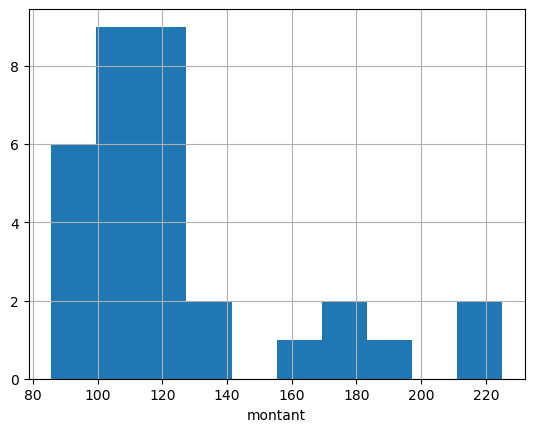

In [140]:
# représentation graphique des valeurs abérentes

result["price"].hist()
plt.xlabel('montant')
plt.show()

In [141]:
# valeur du chiffre d'affaire total sans le montant des outliers 

sum_whitout_outliers = df_final['CA_pro'].sum() - result['price'].sum()

print("le chiffre d'affaire total des articles vendu sont de :",sum_whitout_outliers)

le chiffre d'affaire total des articles vendu sont de : 66582.3


<div style="border: 1px solid RGB(0,150,250);" >
<h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">CONCLUSION</h3>
</div>

Le chiffre d'affaire des outliers représente 3986.3 euros, j'ai fais le choix de ne pas retirer les valeurs abérentes mais plutot de vous les notifier, ne sachant pas les gammes de produits vinicoles allant des vins rares et de collection aux vins de niche et aux vins biologiques..